In [1]:
!pip install pip --upgrade
!pip install pgmpy
!pip install networkx>=3.0
!pip install matplotlib
!pip install termcolor
!pip install optuna
!pip install optuna-dashboard
!pip install optuna-distributed

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import logging

_LOGGER = logging.getLogger(__name__)

# TabularCPD Explaination

### Variable
```variable="Cancer"``` details which variable we are working on

### Variable Card
```variable_card=2``` how many different values the variable can have (0, 1 in this case)

### Evidence
Evidence is the parent variables of this variable. In this case `Cancer` has the parent `Smoker` and `Pollution`
```evidence=["Smoker", "Pollution"]```

The evidence card describes how many different values each parent can have. This means that Smoker can be a value of 0, 1 and Pollution can be a number 0, 1.
```evidence_card=[2, 2]```

### Values
Consider:
```
values=[
    [0.03, 0.05, 0.001, 0.02],
    [0.97, 0.95, 0.999, 0.98]
]
```
Values defines the probabilities of each state given its parent variables
The first row `[0.03, 0.05, 0.001, 0.02]` means `[Smoker=0|Cancer=0, Smoker=0|Cancer=1, Smoker=1|Cancer=0, Smoker=1|Cancer=1]`
The second row `[0.97, 0.95, 0.999, 0.98]` means `[Pollution=0|Cancer=0, Pollution=0|Cancer=1, Pollution=1|Cancer=0, Pollution=1|Cancer=1]`

Basically, each row describes the probabilities given the evidence.










In [3]:
# Define the model structure
model = BayesianNetwork(
    [
        ("Pollution", "Cancer"),
        ("Smoker", "Cancer"),
        ("Cancer", "Xray"),
        ("Potato", "Xray"),
        ("Cancer", "Dyspnoea"),
    ]
)

cpd_poll = TabularCPD(
    variable="Pollution",
    variable_card=2,
    values=[[0.9], [0.1]]
)

cpd_smoke = TabularCPD(
    variable="Smoker",
    variable_card=2,
    values=[[0.3], [0.7]]
)

cpd_potato = TabularCPD(
    variable="Potato",
    variable_card=2,
    values=[[0.4], [0.6]]
)

cpd_cancer = TabularCPD(
    variable="Cancer",
    variable_card=2,
    values=[
        [0.3, 0.95, 0.4, 0.4],
        [0.7, 0.05, 0.6, 0.6]
    ],
    evidence=["Smoker", "Pollution"],
    evidence_card=[2, 2],
)
cpd_xray = TabularCPD(
    variable="Xray",
    variable_card=2,
    values=[
        [0.4, 0.65, 0.4, 0.5],
        [0.6, 0.35, 0.6, 0.5]
    ],
    evidence=["Cancer", "Potato"],
    evidence_card=[2, 2],
)

cpd_dysp = TabularCPD(
    variable="Dyspnoea",
    variable_card=2,
    values=[
        [0.65, 0.3],
        [0.35, 0.7]
    ],
    evidence=["Cancer"],
    evidence_card=[2],
)

# Associating the parameters with the model structure.
model.add_cpds(cpd_poll, cpd_smoke, cpd_potato, cpd_cancer, cpd_xray, cpd_dysp)

# Check if the model is valid
model.check_model()


True

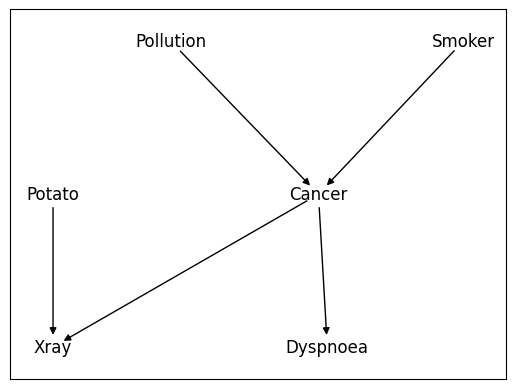

['Potato', 'Cancer']

In [4]:
from type_iii_feedback.utils import get_boundary, draw_network

G = draw_network(model)
labels = {str(x): str(x) for i, x in enumerate(model.nodes)}
target_boundary = get_boundary("Xray", labels, labels, G)
target_boundary

In [5]:
from pgmpy.sampling import BayesianModelSampling

sampler = BayesianModelSampling(model)

# Sample data from the model
data = sampler.forward_sample(size=500)

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--num_clauses", default=100, type=int)
parser.add_argument("--T", default=10, type=int)
parser.add_argument("--s", default=50.0, type=float)
parser.add_argument("--max_included_literals", default=32, type=int)
parser.add_argument("--device", default="CPU", type=str)
parser.add_argument("--weighted_clauses", default=True, type=bool)
parser.add_argument("--epochs", default=10000, type=int)
parser.add_argument("--number-of-state-bits-ta", default=8, type=int)
parser.add_argument("--number-of-state-bits-ind", default=8, type=int)
parser.add_argument("--iii", default=True, type=bool)
args = parser.parse_args("")

FEATURES = list(model.nodes)
TARGET = ["Xray"]




In [7]:
import optuna_distributed
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import time
import optuna
import random
from termcolor import colored

def evaluate_rule(clause, labels=None, blanket=None):

    ret = dict(
        summary="N/A",
        blanket_ratio=0,
        blanket_present=False
    )

    # Add negated label
    if labels is None:
        labels_with_negated = [f"X{i}" for i in range(len(clause/2))] + [f"¬X{i}" for i in range(len(clause/2))]
    else:
        labels_with_negated = labels + [f"¬{l}" for l in labels]

    # Add negated blanket
    if blanket:
        blanket_w_neg = blanket + [f"¬{l}" for l in blanket]
    else:
        blanket_w_neg = []

    # colored(label, "red") if label in blanket_w_neg else

    # Create list of all included literals
    inclusions = set([label for label, literal in zip(labels_with_negated, clause) if literal >= 1])

    if len(inclusions) == 0:
        return ret

    # Remove those in the blanket
    inclusions_without_blanket = inclusions - set(blanket_w_neg)

    # Compute the size difference between
    incl_diff = len(inclusions) - len(inclusions_without_blanket)

    # Blanket must be present if the size of the blanket is in diff to inclusions without blanket
    blanket_present = incl_diff >= len(blanket)

    blanket_ratio = incl_diff / len(inclusions)

    # generate final string
    out = ' ^ '.join([colored(x, "red") if x in blanket_w_neg else x for x in inclusions])

    ret["summary"] = out
    ret["blanket_ratio"] = blanket_ratio
    ret["blanket_present"] = blanket_present

    return ret

def type_iii_optimizer_base(model):
    # Let all clauses be active
    clause_active = np.ones(model.number_of_clauses, dtype=np.uint32)

    # Calculate all clause literals for all classes
    clauses_inclusions = np.vstack(
        [x.calculate_literal_clause_frequency_individual_clause(clause_active) for x in model.clause_banks]
    )

    return clauses_inclusions


def type_iii_optimizer_v1(model):
    """
    This optimizer will only count the ratio of which blanket variables are present
    :param model:
    :return:
    """
    clauses_inclusions = type_iii_optimizer_base(model)

    blanket_ratio = np.zeros(shape=(len(clauses_inclusions,)))
    for i, clause in enumerate(clauses_inclusions):
        rule_data = evaluate_rule(clause, labels=FEATURES, blanket=target_boundary)
        blanket_ratio[i] = rule_data["blanket_ratio"]

    return blanket_ratio.mean()

def type_iii_optimizer_v2(model):
    """
    This optimizer, will maximize the number of rules that have the full blanket present (at least)
    :param model:
    :return:
    """
    clauses_inclusions = type_iii_optimizer_base(model)

    blanket_ratio = np.zeros(shape=(len(clauses_inclusions,)))
    for i, clause in enumerate(clauses_inclusions):
        rule_data = evaluate_rule(clause, labels=FEATURES, blanket=target_boundary)
        blanket_ratio[i] = int(rule_data["blanket_present"])

    return blanket_ratio.sum() / len(blanket_ratio)

class DummyTrial:

    def suggest_int(self, name, _min, _max):
        return random.randint(_min, _max)

    def suggest_float(self, name, _min, _max):
        return random.uniform(_min, _max)

    def suggest_categorical(self, name, cats):
        return random.choice(cats)

    def set_user_attr(self, v0, v1):
        pass

def run_experiment(trial, optimizer):

    import logging
    from tmu.models.classification.vanilla_classifier import TMClassifier

    loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
    for logger in loggers:
        logger.setLevel(logging.WARNING)


    X = data[FEATURES].values
    y = data[TARGET].values.flatten()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)


    num_clauses = trial.suggest_int("num_clauses", 10, 50) # clauses
    num_clauses = num_clauses if num_clauses % 2 == 0 else num_clauses + 1
    sensitivity = trial.suggest_float("sensitivity", 1.0, 300.0) # s
    threshold = trial.suggest_int("threshold", 1, 100) # T
    max_included_literals = args.max_included_literals
    number_of_state_bits_ta = trial.suggest_int("number_of_state_bits_ta", 1, 64)#args.number_of_state_bits_ta
    number_of_state_bits_ind = trial.suggest_int("number_of_state_bits_ind", 1, 64) #args.number_of_state_bits_ind
    platform = "CPU"
    weighted_clauses = True
    type_iii_feedback = True # trial.suggest_categorical("type-iii", [True, False])

    tm = TMClassifier(
        number_of_clauses=num_clauses,
        T=threshold,
        s=sensitivity,
        max_included_literals=max_included_literals,
        number_of_state_bits_ta=number_of_state_bits_ta,
        number_of_state_bits_ind=number_of_state_bits_ind,
        platform=platform,
        weighted_clauses=weighted_clauses,
        type_iii_feedback=type_iii_feedback
    )

    for x in range(args.epochs):
        tm.fit(X_train, y_train)
        y_pred = tm.predict(X_test)

    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_pred, y_pred)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f-score", fscore)
    trial.set_user_attr("support", support)
    trial.set_user_attr("accuracy", accuracy)

    return optimizer(tm)


# Dry run
score = run_experiment(DummyTrial(), lambda m: (type_iii_optimizer_v1(m), type_iii_optimizer_v2(m)))
print(score)


study = optuna_distributed.from_study(optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name=f"type-iii-TM-{int(time.time())}",
    directions=["maximize", "maximize"]
), client=None)



study.optimize(
    lambda trial: run_experiment(trial, lambda m: (type_iii_optimizer_v1(m), type_iii_optimizer_v2(m))),
    n_trials=100000,
    show_progress_bar=False,
    n_jobs=10
)



NameError: name 'np' is not defined

In [ ]:
import pandas as pd
import numpy as np
import logging

_LOGGER = logging.getLogger(__name__)

LITERAL_TYPES = ["Inclusion", "Exclusion"]
literal_freq = tm.literal_clause_frequency()

literal_combined_sum = np.stack(np.split(literal_freq, 2)).sum(axis=0)

weighted_literal_combined_sum = [(FEATURES[i], item) for i, item in enumerate(literal_combined_sum)]

print(weighted_literal_combined_sum)


df = pd.DataFrame(
    columns=FEATURES,
    data=np.split(literal_freq, 2)
)

# Find the two highest values in each row. exclude 0
result = df.apply(lambda x: x[x != 0].nlargest(len(target_boundary)).index.tolist(), axis=1)

for i, item in enumerate(result):
    _LOGGER.info(f"{LITERAL_TYPES[i]}:\t{sorted(item)}")
_LOGGER.info(f"Target:\t\t{sorted(target_boundary)}")

_LOGGER.info("-------------------------")
_LOGGER.info("0 = Inclusion, 1 = Exclusion")
print(df)
